# Корреляционный анализ датасета "100 лучших фильмов 21 века"

Выбрать из каталога любой интересующий dataset и провести его анализ в вольном стиле

Датасет: https://www.kaggle.com/datasets/betlbaak/best-100-movies

Датасет представляет собой коллекцию 100 лучших фильмов 21 века с полными метаданными.
(100 must-watch films with full metadata for analysis and exploration)

**Цель анализа:** Исследовать корреляции между различными характеристиками фильмов (год выпуска, рейтинг, бюджет, кассовые сборы, жанры, режиссёры, актёры) с использованием интерактивных визуализаций.

Результат работы -> интерактивный dashboard с графиками


## Импорт библиотек

In [29]:
%pip install numpy pandas matplotlib wordcloud plotly scipy nbformat


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats

print("✅ Все библиотеки загружены")


✅ Все библиотеки загружены


## Скачивание датасета

Датасет загружается автоматически с Kaggle с помощью библиотеки kagglehub.

In [31]:
import os
import shutil

# Устанавливаем kagglehub если нужно
%pip install -q kagglehub

import kagglehub

# Скачиваем датасет
dataset_path = kagglehub.dataset_download('betlbaak/best-100-movies')
print(f'Датасет скачан в: {dataset_path}')

# Копируем файлы в текущую директорию
for file in os.listdir(dataset_path):
    src = os.path.join(dataset_path, file)
    dst = os.path.join('.', file)
    if os.path.isfile(src):
        shutil.copy2(src, dst)
        print(f'✅ Скопирован: {file}')


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/user1/devpy/python_developer_pro/hw_12/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



100%|██████████| 7.83k/7.83k [00:00<00:00, 7.67MB/s]

Extracting files...
Датасет скачан в: /Users/user1/.cache/kagglehub/datasets/betlbaak/best-100-movies/versions/1
✅ Скопирован: best_100_movies.txt


## Функции для работы с данными

In [32]:
def extract_dataset(zip_path='best-100-movies.zip', extract_to='.'):
    """Автоматическая распаковка датасета"""
    if not os.path.exists(zip_path):
        print(f"❌ Архив {zip_path} не найден!")
        return None

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        csv_files = [f for f in zip_ref.namelist() if f.endswith('.txt') or f.endswith('.csv')]
        if csv_files:
            print(f"✅ Датасет распакован: {csv_files[0]}")
            return os.path.join(extract_to, csv_files[0])
    return None

def load_and_clean_dataset(file_path='best_100_movies.txt'):
    """Загрузка и очистка датасета"""
    if not os.path.exists(file_path):
        print(f"Файл не найден. Попытка распаковки...")
        file_path = extract_dataset()

    df = pd.read_csv(file_path)
    print(f"📊 Записей найдено: {len(df)}")

    # Преобразование числовых колонок
    numeric_cols = ['Rating', 'ReleaseYear', 'Duration(min)', 'Budget(millionUSD)',
                    'BoxOffice(millionUSD)', 'NumAwards', 'Oscar']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

def parse_genres(df):
    """Парсинг жанров"""
    genres_list = []
    for genres_str in df['Genre'].dropna():
        genres = [g.strip() for g in str(genres_str).split(',')]
        genres_list.extend(genres)
    return Counter(genres_list)

def parse_names(df, column):
    """Парсинг имён режиссёров/актёров"""
    names_list = []
    for names_str in df[column].dropna():
        names = [n.strip() for n in str(names_str).split(',')]
        names_list.extend(names)
    return Counter(names_list)

print("✅ Функции определены")


✅ Функции определены


## Загрузка датасета

In [33]:
df = load_and_clean_dataset('best_100_movies.txt')

# Просмотр структуры данных
print("\n📋 Колонки датасета:")
print(df.columns.tolist())
print("\n📊 Размер датасета:", df.shape)
print("\n🔍 Первые строки:")
display(df.head())


📊 Записей найдено: 100

📋 Колонки датасета:
['Id', 'Title', 'Director', 'ReleaseYear', 'Rating', 'Genre', 'Starring', 'Duration(min)', 'Country', 'Budget(millionUSD)', 'BoxOffice(millionUSD)', 'NumAwards', 'Oscar', 'AppleTV', 'AmazonPrime', 'HBOMax', 'Netflix']

📊 Размер датасета: (100, 17)

🔍 Первые строки:


,Id,Title,Director,ReleaseYear,Rating,Genre,Starring,Duration(min),Country,Budget(millionUSD),BoxOffice(millionUSD),NumAwards,Oscar,AppleTV,AmazonPrime,HBOMax,Netflix
0,1,Parasite,Bong Joon-ho,2019,8.5,"Drama, Thriller","Cho Yeo-jeong, Choi Woo-shik, Jang Hye-jin, Le...",132,South Korea,11.4,258.1,50.0,4.0,True,True,True,True
1,2,Mulholland Drive,David Lynch,2001,7.9,"Drama, Mystery","Ann Miller, Justin Theroux, Laura Harring, Nao...",147,United States,15.0,20.1,11.0,0.0,False,True,False,True
2,3,There Will Be Blood,Paul Thomas Anderson,2008,8.2,"Drama, Western","Ciaran Hinds, Daniel Day-Lewis, Paul Dano",158,United States,25.0,76.2,51.0,9.0,True,True,True,True
3,4,In the Mood for Love,Wong Kar‑wai,2000,8.1,"Drama, Romance","Maggie Cheung, Tony Leung Chiu Wai",98,Hong Kong,3.0,16.0,12.0,0.0,True,True,True,False
4,5,Moonlight,Barry Jenkins,2016,7.4,Drama,"Alex R. Hibbert, Mahershala Ali, Naomie Harris...",111,United States,4.0,65.2,35.0,4.0,True,True,False,False


## Основная статистика

In [34]:
print("="*80)
print("СТАТИСТИЧЕСКИЙ ОБЗОР ДАТАСЕТА")
print("="*80)

print(f"\n📈 Всего фильмов: {len(df)}")
print(f"📅 Период: {df['ReleaseYear'].min():.0f} - {df['ReleaseYear'].max():.0f}")
print(f"⭐ Средний рейтинг: {df['Rating'].mean():.2f} (σ = {df['Rating'].std():.2f})")
print(f"⏱️ Средняя продолжительность: {df['Duration(min)'].mean():.1f} минут")
print(f"💰 Средний бюджет: ${df['Budget(millionUSD)'].mean():.1f} млн")
print(f"🎬 Средние кассовые сборы: ${df['BoxOffice(millionUSD)'].mean():.1f} млн")
print(f"🏆 Среднее количество наград: {df['NumAwards'].mean():.1f}")
print(f"🎭 Среднее количество Оскаров: {df['Oscar'].mean():.2f}")

# Описательная статистика
print("\n📊 Описательная статистика:")
display(df[['ReleaseYear', 'Rating', 'Duration(min)', 'Budget(millionUSD)',
            'BoxOffice(millionUSD)', 'NumAwards', 'Oscar']].describe())


СТАТИСТИЧЕСКИЙ ОБЗОР ДАТАСЕТА

📈 Всего фильмов: 100
📅 Период: 2000 - 2024
⭐ Средний рейтинг: 7.82 (σ = 0.52)
⏱️ Средняя продолжительность: 124.1 минут
💰 Средний бюджет: $39.9 млн
🎬 Средние кассовые сборы: $198.1 млн
🏆 Среднее количество наград: 18.3
🎭 Среднее количество Оскаров: 1.55

📊 Описательная статистика:


,ReleaseYear,Rating,Duration(min),Budget(millionUSD),BoxOffice(millionUSD),NumAwards,Oscar
count,100.000000,100.000000,100.000000,90.000000,99.000000,98.000000,98.000000
mean,2009.950000,7.821000,124.100000,39.924444,198.106061,18.306122,1.551020
std,6.848099,0.521903,23.027213,50.042113,267.161375,14.693015,2.450005
min,2000.000000,6.200000,80.000000,0.800000,0.200000,0.000000,0.000000
25%,2004.000000,7.500000,107.750000,8.225000,29.150000,6.000000,0.000000
50%,2010.000000,7.800000,121.000000,19.000000,76.200000,14.000000,1.000000
75%,2015.000000,8.200000,135.000000,56.600000,260.300000,29.750000,2.000000
max,2024.000000,9.100000,180.000000,200.000000,1350.000000,51.000000,12.000000


## Корреляционный анализ

In [35]:
print("\n" + "="*80)
print("КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")
print("="*80)

# Ключевые корреляции
corr_year_rating = df['ReleaseYear'].corr(df['Rating'])
corr_budget_revenue = df['Budget(millionUSD)'].corr(df['BoxOffice(millionUSD)'])
corr_rating_oscar = df['Rating'].corr(df['Oscar'])
corr_duration_rating = df['Duration(min)'].corr(df['Rating'])
corr_budget_rating = df['Budget(millionUSD)'].corr(df['Rating'])

print(f"\n🔍 Год выпуска vs Рейтинг: {corr_year_rating:.3f}")
print(f"💰 Бюджет vs Кассовые сборы: {corr_budget_revenue:.3f}")
print(f"⭐ Рейтинг vs Оскары: {corr_rating_oscar:.3f}")
print(f"⏱️ Продолжительность vs Рейтинг: {corr_duration_rating:.3f}")
print(f"💵 Бюджет vs Рейтинг: {corr_budget_rating:.3f}")

# Топ жанры
print("\n🎭 Топ-5 жанров:")
genres_count = parse_genres(df)
for i, (genre, count) in enumerate(genres_count.most_common(5), 1):
    print(f"   {i}. {genre}: {count} фильмов")

# Топ режиссёры
print("\n🎬 Топ-5 режиссёров:")
directors_count = parse_names(df, 'Director')
for i, (director, count) in enumerate(directors_count.most_common(5), 1):
    print(f"   {i}. {director}: {count} фильмов")

# Топ актёры
print("\n🌟 Топ-5 актёров:")
actors_count = parse_names(df, 'Starring')
for i, (actor, count) in enumerate(actors_count.most_common(5), 1):
    print(f"   {i}. {actor}: {count} фильмов")



КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

🔍 Год выпуска vs Рейтинг: -0.292
💰 Бюджет vs Кассовые сборы: 0.820
⭐ Рейтинг vs Оскары: 0.341
⏱️ Продолжительность vs Рейтинг: 0.295
💵 Бюджет vs Рейтинг: 0.323

🎭 Топ-5 жанров:
   1. Drama: 40 фильмов
   2. Comedy: 24 фильмов
   3. Thriller: 23 фильмов
   4. Romance: 21 фильмов
   5. Crime: 15 фильмов

🎬 Топ-5 режиссёров:
   1. Christopher Nolan: 5 фильмов
   2. Paul Thomas Anderson: 4 фильмов
   3. Alfonso Cuarón: 4 фильмов
   4. Ethan Coen: 3 фильмов
   5. Joel Coen: 3 фильмов

🌟 Топ-5 актёров:
   1. Brad Pitt: 6 фильмов
   2. Michael Caine: 4 фильмов
   3. Leonardo DiCaprio: 4 фильмов
   4. George Clooney: 4 фильмов
   5. Paul Dano: 3 фильмов


## 1. Распределение фильмов по жанрам

In [36]:
genres_count = parse_genres(df)
genres_df = pd.DataFrame(genres_count.most_common(15), columns=['Genre', 'Count'])

# Используем go.Bar для явного контроля данных
fig = go.Figure(data=[
    go.Bar(
        x=genres_df['Genre'].tolist(),
        y=genres_df['Count'].tolist(),
        marker_color=genres_df['Count'].tolist(),
        marker_colorscale='Viridis',
        hovertemplate='%{x}: %{y} фильмов<extra></extra>'
    )
])

fig.update_layout(
    title='Распределение фильмов по жанрам (топ-15)',
    xaxis_title='Жанр',
    yaxis_title='Количество фильмов',
    height=500,
    xaxis_tickangle=-45
)
fig.show()

## 2. Топ режиссёры и актёры

In [37]:
directors_count = parse_names(df, 'Director')
actors_count = parse_names(df, 'Starring')

top_directors = pd.DataFrame(directors_count.most_common(10), columns=['Name', 'Count'])
top_actors = pd.DataFrame(actors_count.most_common(10), columns=['Name', 'Count'])

# Переворачиваем порядок, чтобы топ был вверху графика
top_directors = top_directors.iloc[::-1].reset_index(drop=True)
top_actors = top_actors.iloc[::-1].reset_index(drop=True)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Топ-10 режиссёров', 'Топ-10 актёров')
)

fig.add_trace(
    go.Bar(x=top_directors['Count'].tolist(), y=top_directors['Name'].tolist(), orientation='h',
           name='Режиссёры', marker_color='indianred',
           hovertemplate='%{y}: %{x} фильмов<extra></extra>'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=top_actors['Count'].tolist(), y=top_actors['Name'].tolist(), orientation='h',
           name='Актёры', marker_color='lightsalmon',
           hovertemplate='%{y}: %{x} фильмов<extra></extra>'),
    row=1, col=2
)

fig.update_layout(height=500, title_text="Топ режиссёры и актёры в лучших фильмах")
fig.show()


## 3. Облако слов из названий фильмов

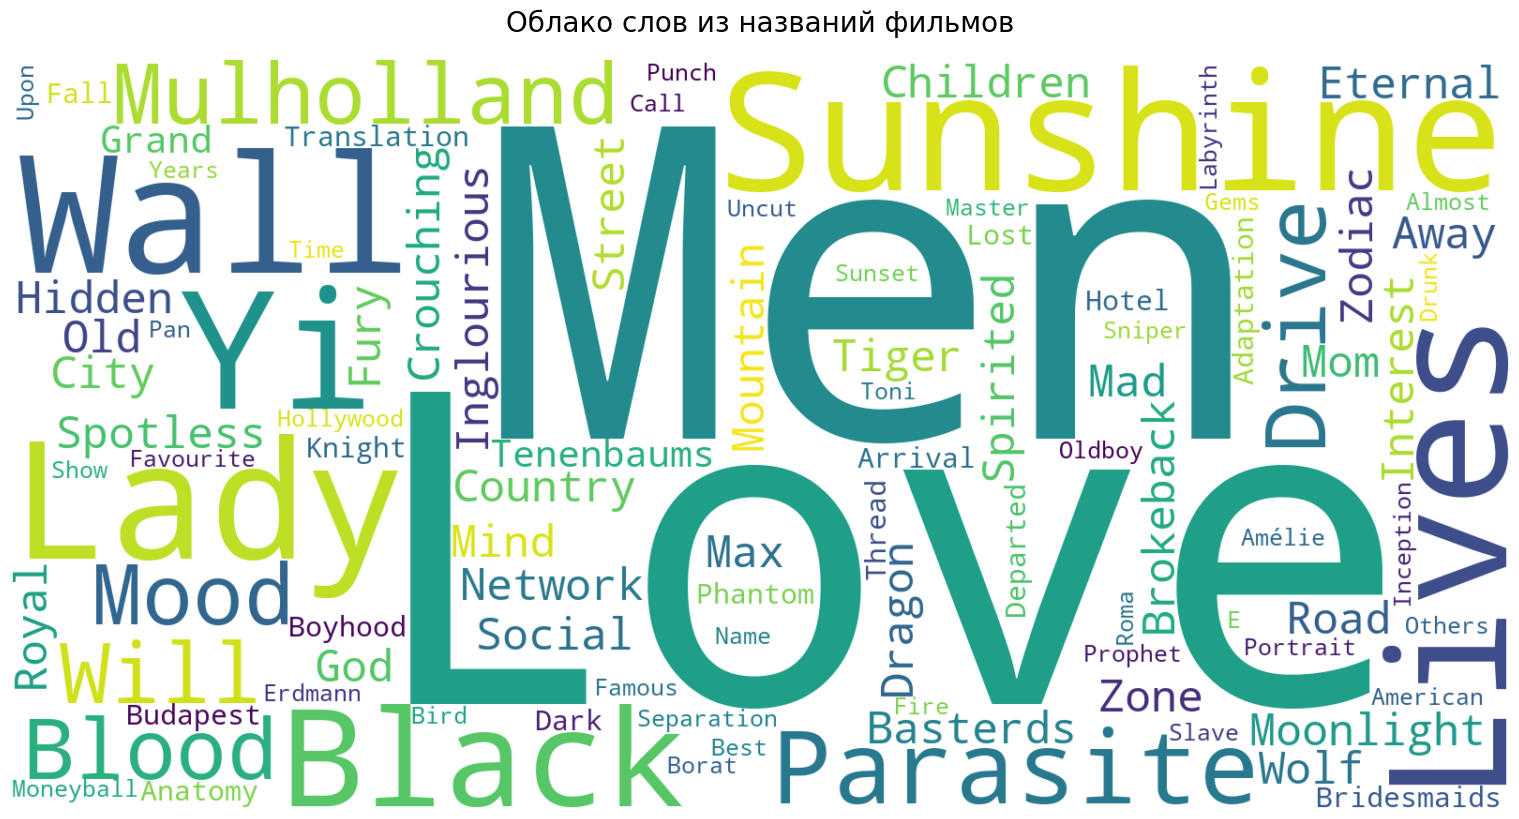

In [38]:
titles_text = ' '.join(df['Title'].dropna().astype(str))

stop_words = set(STOPWORDS)
stop_words.update(['the', 'a', 'an', 'and', 'or', 'of', 'in', 'to'])

wordcloud = WordCloud(
    background_color="white",
    width=1600, height=800,
    max_words=100,
    stopwords=stop_words,
    colormap='viridis'
).generate(titles_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Облако слов из названий фильмов", fontsize=20, pad=20)
plt.tight_layout(pad=0)
plt.show()


## Экспорт в HTML Dashboard

Для создания единого интерактивного dashboard запустите Python скрипт:
```bash
python best_100_movies_pandas.py
```

Это создаст файл `interactive_dashboard.html` со всеми интерактивными графиками.

In [39]:
# Запуск скрипта для генерации dashboard
import subprocess
result = subprocess.run(['python', 'best_100_movies_pandas.py'], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print("Ошибки:", result.stderr)


🎬 Начало анализа датасета '100 лучших фильмов 21 века'
Записей найдено: 100
Записей после очистки: 100

АНАЛИЗ ДАТАСЕТА '100 ЛУЧШИХ ФИЛЬМОВ 21 ВЕКА'

Всего фильмов: 100
Период: 2000 - 2024
Средний рейтинг: 7.82 (σ = 0.52)
Средняя продолжительность: 124.1 минут

--- Топ-5 жанров ---
Drama: 40 фильмов
Comedy: 24 фильмов
Thriller: 23 фильмов
Romance: 21 фильмов
Crime: 15 фильмов

--- Топ-5 режиссёров ---
Christopher Nolan: 5 фильмов
Paul Thomas Anderson: 4 фильмов
Alfonso Cuarón: 4 фильмов
Ethan Coen: 3 фильмов
Joel Coen: 3 фильмов


Создание интерактивного dashboard...
✅ Dashboard сохранён в файл: interactive_dashboard.html

✅ Анализ завершён! Откройте файл interactive_dashboard.html в браузере для просмотра интерактивных графиков.



## Выводы

1. **Жанры**: Драма является доминирующим жанром среди лучших фильмов 21 века (40 фильмов), за ней Comedy (24) и Thriller (23)
2. **Режиссёры**: Christopher Nolan лидирует с 5 фильмами в топ-100, за ним Paul Thomas Anderson (4) и Alfonso Cuarón (4)
3. **Актёры**: Brad Pitt - самый популярный актёр (6 фильмов), Michael Caine и Leonardo DiCaprio (по 4 фильма)